In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from bus_cost_utils import *
from cost_per_bus_nb_scripts import *
from IPython.display import Markdown, display
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore
from IPython.display import Markdown, display

In [2]:
merged_data = pd.read_parquet(f'{GCS_PATH}cleaned_no_outliers_cpb_analysis_data_merge.parquet')

In [3]:
# for subsetting ZEB and nonZEB
zeb_list =[
    "BEB",
    "FCEB",
    "electric (not specified)",
    "zero-emission bus (not specified)",
]

non_zeb_list =[
    "CNG",
    "ethanol",
    "low emission (hybrid)",
    "low emission (propane)",
    "mix (zero and low emission)",
]

In [4]:
# means and standard deviations
# for graphs
cpb_mean = merged_data["cost_per_bus"].mean()
cpb_std = merged_data["cost_per_bus"].std()

#testing weighted average calculation for sub-set non-zeb and zeb
zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(zeb_list)]["bus_count"].sum())
non_zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(non_zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(non_zeb_list)]["bus_count"].sum())

In [5]:
def new_cpb_aggregate(df: pd.DataFrame, column="transit_agency") -> pd.DataFrame:
    """
    function to aggregate compiled data by different categories:
        "transit agency", 
        "propulsion type", 
        "bus_size_type",
        "new_project_type"
    aggregate on columns:
        "project_title"
        "ppno"
        "total_cost"
        "bus_count"
        
    Then, cost per bus is calculated AFTER the aggregation.
    """
    df_agg = (
        df.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_project_count_ppno=("ppno", "count"),
            total_agg_cost=("total_cost", "sum"),
            total_bus_count=("bus_count", "sum"),
            #new_prop_type=("prop_type","max")
        )
        .reset_index()
    )
    df_agg["new_cost_per_bus"] = (df_agg["total_agg_cost"] / df_agg["total_bus_count"]).astype("int64")
    
    #calculate zscore
    df_agg["new_zscore_cost_per_bus"] = zscore(df_agg["new_cost_per_bus"])
    
    #flag outliers
    df_agg["new_is_cpb_outlier?"] = df_agg["new_zscore_cost_per_bus"].apply(outlier_flag)
    
    return df_agg

In [81]:
def bus_min_max_summary(data:pd.DataFrame, col1:str, col_list=["transit_agency",
                                                     "total_agg_cost",
                                                     "total_bus_count",
                                                     "new_cost_per_bus"]):
    """
    function to display min/max of specific column in aggregated bus df.
    
    """

    return display(Markdown(f"**Max {col1}**"),
    data[data[col1] == data[col1].max()][col_list],
    Markdown(f"**Min {col1}**"),
    data[data[col1] == data[col1].min()][col_list])
                  

In [6]:
def make_chart(y_col: str, title: str, data: pd.DataFrame, x_col: str):
    """
    function to create chart. sorts values by y_col ascending."""
    
    data.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.ticklabel_format(style="plain", axis="y")
    plt.show()

In [7]:
def dist_curve(
    df: pd.DataFrame,
    mean: str,
    std: str,
    title: str,
    xlabel: str,
):
    """
    function to make distribution curve. uses the "cpb" column of the df.
    """
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    # mean line
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )
    # mean+1std
    plt.axvline(
        mean + std,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Standard Deviation: ${std:,.2f}",
    )
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 2), color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 3), color="green", linestyle="dashed", linewidth=2)

    plt.title(title + " with Mean and Standard Deviation")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Turn off scientific notation on x-axis?
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.legend()
    plt.show()

    return

In [8]:
# aggregating by big categories
agg_agency = new_cpb_aggregate(merged_data)
agg_prop = new_cpb_aggregate(merged_data, column="prop_type")
agg_bus_size = new_cpb_aggregate(merged_data, column="bus_size_type")
agg_source = new_cpb_aggregate(merged_data, column="source")

In [9]:
# subsetting ZEB and nonZEB data
zeb_projects = merged_data[merged_data["prop_type"].isin(zeb_list)]

non_zeb_projects = merged_data[merged_data["prop_type"].isin(non_zeb_list)]

In [10]:
#pivot table to get totals for each prop type

pivot_prop_type = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()
pivot_prop_type["cost_per_bus"] = (pivot_prop_type["total_cost"] / pivot_prop_type["bus_count"]).astype("int64")

In [11]:
#pivot for ZEB data

pivot_zeb_prop = pd.pivot_table(
    #filted incoming DF for zeb prop types
    zeb_projects,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()              

pivot_zeb_prop["cost_per_bus"] = (pivot_zeb_prop["total_cost"] / pivot_zeb_prop["bus_count"]).astype("int64")

In [12]:
#pivot for non-ZEB data

pivot_non_zeb_prop = pd.pivot_table(
    #filted incoming DF for non-zeb prop types
    non_zeb_projects,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_non_zeb_prop["cost_per_bus"] = (pivot_non_zeb_prop["total_cost"] / pivot_non_zeb_prop["bus_count"]).astype("int64")

In [108]:
# pivot for bus sizes

pivot_size = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    # multi-index pivot
    index = ["prop_type","bus_size_type"],
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
)

pivot_size["cost_per_bus"] = (pivot_size["total_cost"] / pivot_size["bus_count"]).astype("int64")

In [109]:
pivot_size

bus_count  \
prop_type                         bus_size_type                                  
BEB                               articulated                             12.0   
                                  standard/conventional (30ft-45ft)      151.0   
CNG                               cutaway                                  3.0   
                                  not specified                          209.0   
                                  standard/conventional (30ft-45ft)       40.0   
FCEB                              not specified                           29.0   
                                  standard/conventional (30ft-45ft)       73.0   
electric (not specified)          articulated                             29.0   
                                  not specified                           15.0   
ethanol                           not specified                            9.0   
low emission (hybrid)             not specified                          145.0   
low emission (propane)            not specified                           44.0   
mix (zero and low emission)       not specified                          125.0   
not specified                     cutaway                                149.0   
                                  not specified                          162.0   
                                  over-the-road                           14.0   
zero-emission bus (not specified) not specified                          143.0   
Grand Total                                                             1352.0   

                                                                     total_cost  \
prop_type                         bus_size_type                                   
BEB                               articulated                          18759576   
                                  standard/conventional (30ft-45ft)   148472913   
CNG                               cutaway                               1162000   
                                  not specified                       171977140   
                                  standard/conventional (30ft-45ft)     2900000   
FCEB                              not specified                        38070971   
                                  standard/conventional (30ft-45ft)    82880364   
electric (not specified)          articulated                          39478000   
                                  not specified                        17200000   
ethanol                           not specified                         1006750   
low emission (hybrid)             not specified                        91824361   
low emission (propane)            not specified                         8403969   
mix (zero and low emission)       not specified                        36775430   
not specified                     cutaway                              15532500   
                                  not specified                        16503904   
                                  over-the-road                         9516000   
zero-emission bus (not specified) not specified                       128156513   
Grand Total                                                           828620391   

                                                                     cost_per_bus  
prop_type                         bus_size_type                                    
BEB                               articulated                             1563298  
                                  standard/conventional (30ft-45ft)        983264  
CNG                               cutaway                                  387333  
                                  not specified                            822857  
                                  standard/conventional (30ft-45ft)         72500  
FCEB                              not specified                           1312792  
                                  standard/conventional (30ft-45ft)       1135347  
electric (n

In [14]:
#pivot for data soruces
pivot_source = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "source",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

pivot_source["cost_per_bus"] = (pivot_source["total_cost"] / pivot_source["bus_count"]).astype("int64")

In [90]:
# new summary

new_summary = f"""

# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

The initial dataset contained close to 300 projects, but was paired down due to projects including components other than buses. Examples include: projects that constructed new facilities, trainings or other non-bus related items like trains and sea farries were excluded.
The resulting dataset only contained projects that were solely used to procure buses. 

{len(merged_data)} projects were determined to contain solely bus purchases. 
These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.


Breakdown of each data souce:
{pivot_source.to_markdown(index=False)}


**ZEB buses include:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric 
- fuel cell electric

**Non-ZEB buses include:**
- CNG 
- ethanol 
- ow emission (hybrid, propane) 
- diesel 
- gas

Below are charts and tables that summarize the findings.

"""
display(
    Markdown(new_summary)
)



# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

The initial dataset contained close to 300 projects, but was paired down due to projects including components other than buses. Examples include: projects that constructed new facilities, trainings or other non-bus related items like trains and sea farries were excluded.
The resulting dataset only contained projects that were solely used to procure buses. 

88 projects were determined to contain solely bus purchases. 
These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.


Breakdown of each data souce:
| source      |   bus_count |   total_cost |   cost_per_bus |
|:------------|------------:|-------------:|---------------:|
| dgs         |         236 |    250112853 |        1059800 |
| fta         |         883 |    391257025 |         443099 |
| tircp       |         233 |    187250513 |         803650 |
| Grand Total |        1352 |    828620391 |         612884 |


**ZEB buses include:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric 
- fuel cell electric

**Non-ZEB buses include:**
- CNG 
- ethanol 
- ow emission (hybrid, propane) 
- diesel 
- gas

Below are charts and tables that summarize the findings.



In [91]:
#summary stuff
display(
    Markdown("**ZEB Cost Summary**"),
    pivot_zeb_prop,
    
    Markdown("**Non-ZEB Cost Summary**"),
    pivot_non_zeb_prop,
    
    Markdown("The remaining buses did not specify a propulsion type")
)

**ZEB Cost Summary**

,prop_type,bus_count,total_cost,cost_per_bus
0,BEB,163.0,167232489,1025966
1,FCEB,102.0,120951335,1185797
2,electric (not specified),44.0,56678000,1288136
3,zero-emission bus (not specified),143.0,128156513,896199
4,Grand Total,452.0,473018337,1046500


**Non-ZEB Cost Summary**

,prop_type,bus_count,total_cost,cost_per_bus
0,CNG,252.0,176039140,698568
1,ethanol,9.0,1006750,111861
2,low emission (hybrid),145.0,91824361,633271
3,low emission (propane),44.0,8403969,190999
4,mix (zero and low emission),125.0,36775430,294203
5,Grand Total,575.0,314049650,546173


The remaining buses did not specify a propulsion type

In [113]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies has the highest and lowest overall cost per bus?"))
#bus_min_max_summary(data=agg_agency,col1="new_cost_per_bus")

In [114]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies has the highest and lowest overall procurement cost?"))
#bus_min_max_summary(data=agg_agency,col1="total_agg_cost")

In [115]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies procured the has the most and least overal number of buses?"))
#bus_min_max_summary(data=agg_agency,col1="total_bus_count")

In [95]:
## min max values of just ZEB projects
new_cols =[
    "transit_agency",
    "prop_type",
    "total_cost",
    "bus_count",
    "cost_per_bus"]

display(Markdown("## Which Agneices had the highest and lowest ZEB cost per bus?")),
bus_min_max_summary(data=zeb_projects, col1="cost_per_bus", col_list=new_cols)

## Which Agneices had the highest and lowest ZEB cost per bus?

**Max cost_per_bus**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
76,University of California - San Diego,BEB,4134000,2.0,2067000


**Min cost_per_bus**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
45,City of Wasco,zero-emission bus (not specified),1543000,3.0,514333


In [96]:
display(Markdown(
    "## Which Agencies procured the most and least amount of ZEBs?"
))
bus_min_max_summary(data=zeb_projects, col1="bus_count", col_list=new_cols)


## Which Agencies procured the most and least amount of ZEBs?

**Max bus_count**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
44,City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.0,917767


**Min bus_count**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
70,"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.0,847214
82,City of San Luis Obispo,BEB,859270,1.0,859270


In [97]:
display(Markdown(
    "## Which Agencies had the most and least total ZEB cost?"
))
bus_min_max_summary(data=zeb_projects, col1="total_cost", col_list=new_cols)

## Which Agencies had the most and least total ZEB cost?

**Max total_cost**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
44,City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.0,917767


**Min total_cost**

,transit_agency,prop_type,total_cost,bus_count,cost_per_bus
70,"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.0,847214


In [92]:
# all buses
# dont know if i need this anymore

#dist_curve(
#    df=merged_data,
#    mean=cpb_mean,
#    std=cpb_std,
#    title="all buses, cost per bus distribution",
#    xlabel="cost per bus, $ million(s)",
#)

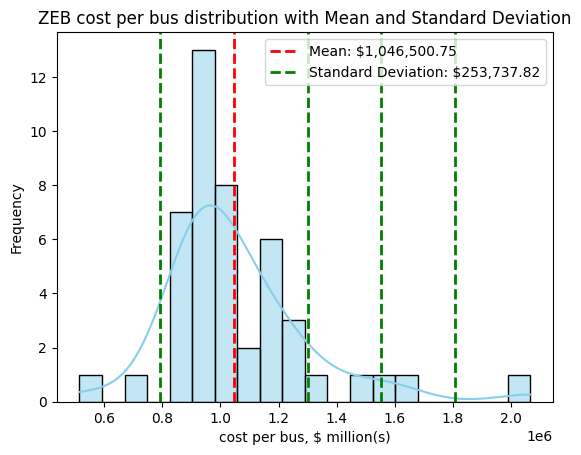

In [98]:
# ZEB cost per bus 
dist_curve(
    df=zeb_projects,
    #using the accounting, weighted average approach to mean (total cost/total number of buses)
    mean=zeb_cpb_wt_avg,
    # need to investigate if std needs to be weighted as well?
    std=zeb_projects["cost_per_bus"].std(),
    title="ZEB cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)

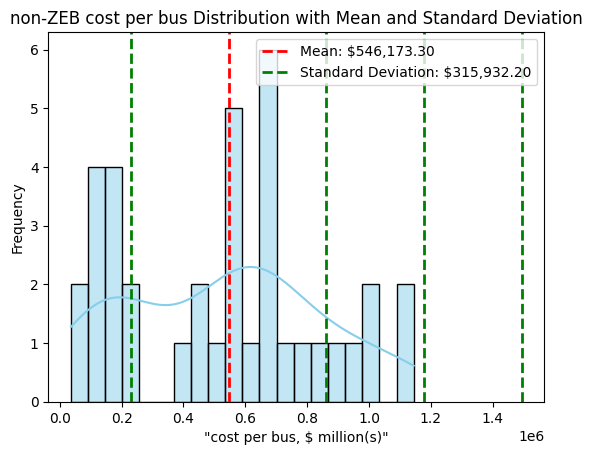

In [99]:
# non-zeb cost per bus

#dist_curve(
#    df=non_zeb_projects,
#    mean=non_zeb_cpb_wt_avg,
#    std=non_zeb_projects["cost_per_bus"].std(),
#    title="non-ZEB cost per bus Distribution",
#    xlabel='"cost per bus, $ million(s)"',
#)

In [112]:
display(
    Markdown("## What is the breakdown of Propulsion Type and Bus Size Category?"),
    pivot_size
)

## What is the breakdown of Propulsion Type and Bus Size Category?

bus_count  \
prop_type                         bus_size_type                                  
BEB                               articulated                             12.0   
                                  standard/conventional (30ft-45ft)      151.0   
CNG                               cutaway                                  3.0   
                                  not specified                          209.0   
                                  standard/conventional (30ft-45ft)       40.0   
FCEB                              not specified                           29.0   
                                  standard/conventional (30ft-45ft)       73.0   
electric (not specified)          articulated                             29.0   
                                  not specified                           15.0   
ethanol                           not specified                            9.0   
low emission (hybrid)             not specified                          145.0   
low emission (propane)            not specified                           44.0   
mix (zero and low emission)       not specified                          125.0   
not specified                     cutaway                                149.0   
                                  not specified                          162.0   
                                  over-the-road                           14.0   
zero-emission bus (not specified) not specified                          143.0   
Grand Total                                                             1352.0   

                                                                     total_cost  \
prop_type                         bus_size_type                                   
BEB                               articulated                          18759576   
                                  standard/conventional (30ft-45ft)   148472913   
CNG                               cutaway                               1162000   
                                  not specified                       171977140   
                                  standard/conventional (30ft-45ft)     2900000   
FCEB                              not specified                        38070971   
                                  standard/conventional (30ft-45ft)    82880364   
electric (not specified)          articulated                          39478000   
                                  not specified                        17200000   
ethanol                           not specified                         1006750   
low emission (hybrid)             not specified                        91824361   
low emission (propane)            not specified                         8403969   
mix (zero and low emission)       not specified                        36775430   
not specified                     cutaway                              15532500   
                                  not specified                        16503904   
                                  over-the-road                         9516000   
zero-emission bus (not specified) not specified                       128156513   
Grand Total                                                           828620391   

                                                                     cost_per_bus  
prop_type                         bus_size_type                                    
BEB                               articulated                             1563298  
                                  standard/conventional (30ft-45ft)        983264  
CNG                               cutaway                                  387333  
                                  not specified                            822857  
                                  standard/conventional (30ft-45ft)         72500  
FCEB                              not specified                           1312792  
                                  standard/conventional (30ft-45ft)       1135347  
electric (n

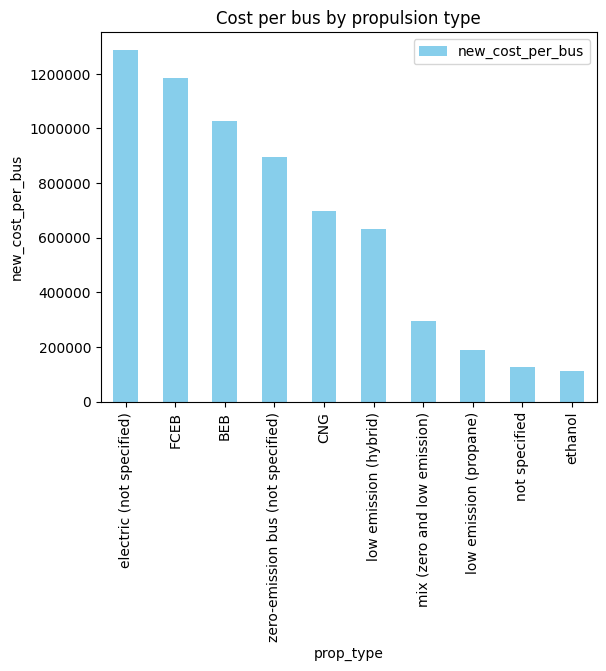

None

,prop_type,new_cost_per_bus
3,electric (not specified),1288136
2,FCEB,1185797
0,BEB,1025966
9,zero-emission bus (not specified),896199
1,CNG,698568
5,low emission (hybrid),633271
7,mix (zero and low emission),294203
6,low emission (propane),190999
8,not specified,127853
4,ethanol,111861


In [48]:
display(
# cpb by prop type
make_chart("new_cost_per_bus", "Cost per bus, by propulsion type", x_col="prop_type", data=agg_prop),

# pivot table to
agg_prop[["prop_type","new_cost_per_bus"]].sort_values(by="new_cost_per_bus", ascending=False)
)

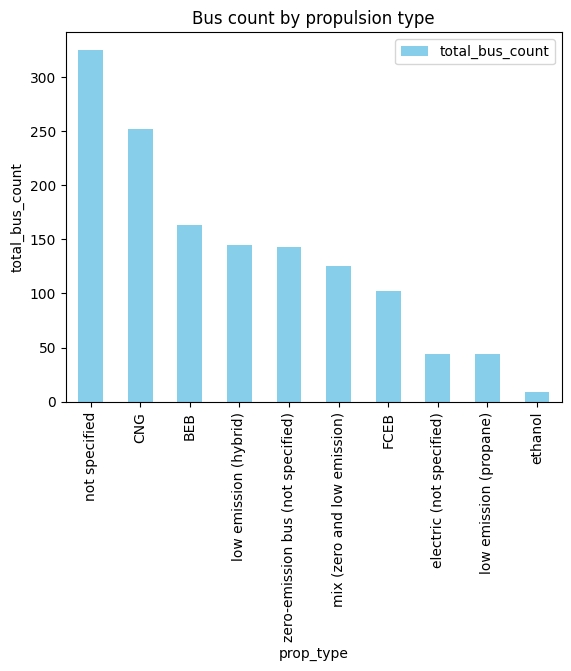

None

,prop_type,total_bus_count
8,not specified,325.0
1,CNG,252.0
0,BEB,163.0
5,low emission (hybrid),145.0
9,zero-emission bus (not specified),143.0
7,mix (zero and low emission),125.0
2,FCEB,102.0
3,electric (not specified),44.0
6,low emission (propane),44.0
4,ethanol,9.0


In [49]:
display(
# bus count by prop type
make_chart("total_bus_count", "Bus counts, by propulsion type", x_col="prop_type", data=agg_prop),
# pivot table to
agg_prop[["prop_type","total_bus_count"]].sort_values(by="total_bus_count", ascending=False)
)

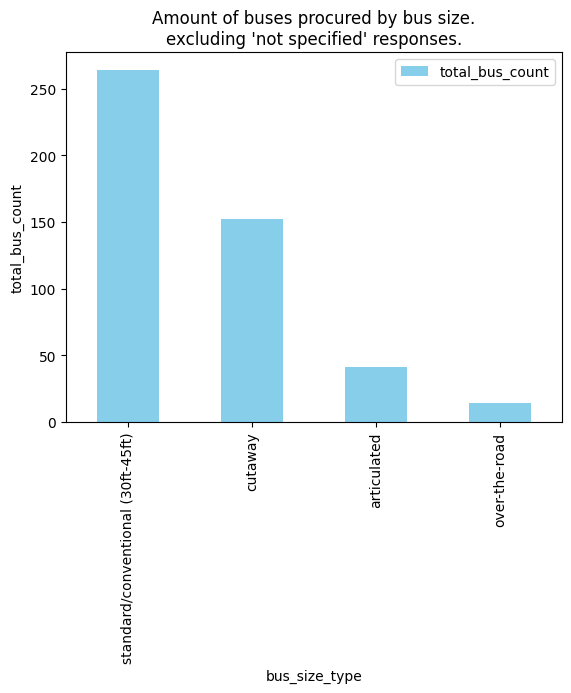

None

,bus_size_type,total_bus_count
0,articulated,41.0
1,cutaway,152.0
2,not specified,881.0
3,over-the-road,14.0
4,standard/conventional (30ft-45ft),264.0


In [52]:
#bus size bar chart
display(
make_chart("total_bus_count", """Bus Size Count.
excluding 'not specified' responses.""", x_col="bus_size_type",data=agg_bus_size[agg_bus_size["bus_size_type"]!="not specified"]),
agg_bus_size[["bus_size_type","total_bus_count"]]
)


In [23]:
conclusion = f"""
**Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is ~$1,000,000, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Trasnit
Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configuable options is outside the scope of data provided. 
"""
display(
    Markdown(conclusion)
)


**Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is ~$1,000,000, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Trasnit
Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configuable options is outside the scope of data provided. 


-------
# Start of old stuff

In [24]:
Markdown(summary)


## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:

1. 130 projects from FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. 124 projects TIRCP project data (state-funded, California only)
3. 35 projects DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc..

The compiled dataset includes **289** total transit related projects. However, the initial dataset included projects that encompassed bus procurement and other components such as charging installation and facility construction, as well as non-bus related projects (ferries, trains). The dataset was filtered to exclude projects that were not bus related, indicated 0 buses procured, and projects that contained construction/installation work. **87** projects remained that specified the number of buses to procure and explicitly described procuring buses (bus only projects). 

Number of bus only contracts from each dataset 
- FTA: **43**
- TIRCP: **9**
- DGS: **35**


The remaining bus only projects were categorized into different propulsion types and bus sizes, a “cost per bus” value was calculated, and outliers removed.

A overall summary is provided below:
- Total projects: **298**
- Number of projects with mix bus procurement and other components, also non-bus projects: **204** 
- Number of bus only projects: **87**
- Total dollars awarded to bus only projects: **`$831,843,715.00`**
- Total number of buses: **1353.0**
- Most common propulsion type procured for bus only projects: **BEB** at **30** projects
- Number of ZEB buses* procured: **452.0**
- Number of non-ZEB buses** procured: **575.0**
- Overall average cost per bus (ZEB & non-ZEB) is `$792,635.34` (std `$396,712.61`)
- ZEB average cost per bus is `$1,056,659.30` (std `$253,737.82`)
- Non-ZEB average cost per bus is `$528,106.49` (std `$315,932.20`) 

`*`ZEB buses include: zero-emission (not specified), electric (not specified), battery electric, fuel cell electric

`**`Non-ZEB buses include: CNG, ethanol, low emission (hybrid, propane), diesel, gas.


Below are key charts that visualize more findings:




In [25]:
# all bus distribution
display(Markdown(all_bus_desc))

dist_curve(
    df=no_outliers,
    mean=cpb_mean,
    std=cpb_std,
    title="all buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)


## All buses (ZEB and non-ZEB) cost/bus distribution curve.
This chart shows the cost per bus distribution of all bus only projects.


KeyError: 'cost_per_bus'

In [ ]:
# ZEB dist curve
display(Markdown(zeb_desc))

dist_curve(
    df=zeb_no_outliers,
    mean=zeb_only_mean,
    std=zeb_only_std,
    title="ZEB only cost/bus Distribution",
    xlabel="cost per bus, $ million(s)",
)

In [ ]:
# non_zeb distribution
display(Markdown(non_zeb_desc))

dist_curve(
    non_zeb_no_outliers,
    non_zeb_only_mean,
    non_zeb_only_std,
    title="non-ZEB only cost/bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
)


## Cost per bus by propulsion type. 


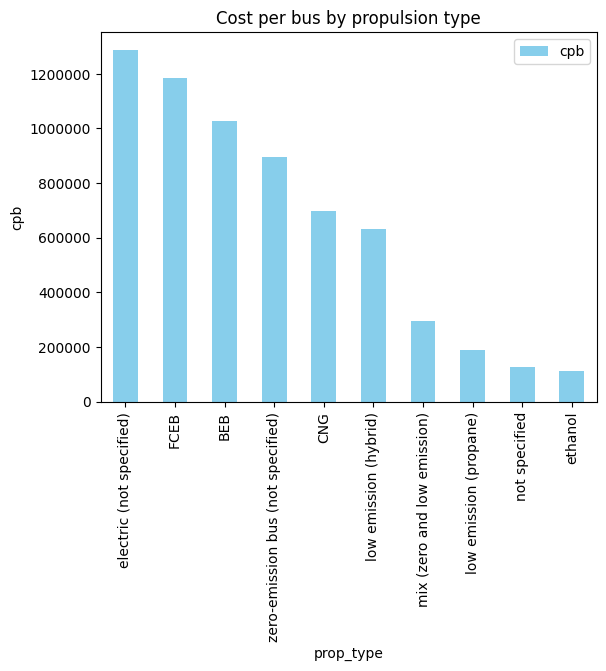

In [26]:
# COST PER BUS BY PROP TYPE
display(Markdown(cpb_prop_type_desc))
make_chart("cpb", "Cost per bus by propulsion type", x_col="prop_type", data=prop_agg)


## Bus count by propulsion type. 


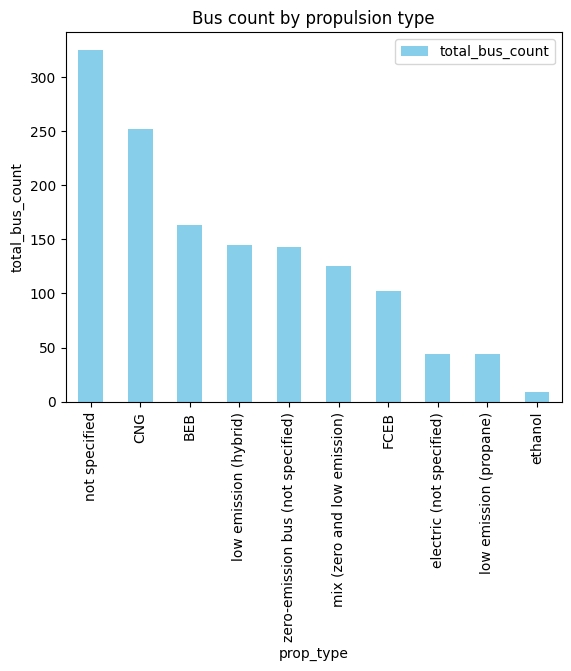

In [27]:
# bus count BY PROP TYPE
display(Markdown(bus_count_prop_type_desc))
make_chart(
    "total_bus_count", 
    "Bus count by propulsion type",
    x_col="prop_type",
    data=prop_agg
)

In [28]:
display(Markdown(conclusion))


**Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is ~$1,000,000, roughly twice the price of a conventional, non-ZEB.
The variance in cost depends mainly on the options the Trasnit
Agencies chooses. Highly optioned/customized buses contribute to high cost.
Unfortunately, analyzing the cost of configuable options is outside the scope of data provided. 
